# Potential Talents

- Author: Yumo Bai
- Email: baiym104@gmail.com
- Date: Mar 16, 2023

## Loading Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Wrangling

In [2]:
df = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


### Wrangling `location`

We have the current job title of the candidates as well as their location and how many connections they have. The location could have been a criteria for initial ranking if there was information given about the location of the company and if there exists any geological preference when selecting a candidate.

We could also argue that the location distribution of candidates applying for this job represents the size of the labor force at that location and thereby imply a higher likelihood of a candidate having more human resource comparing to candidates from a location with less number of candidates.

We can get a sense of the candidate distribution by processing the location data and plotting.

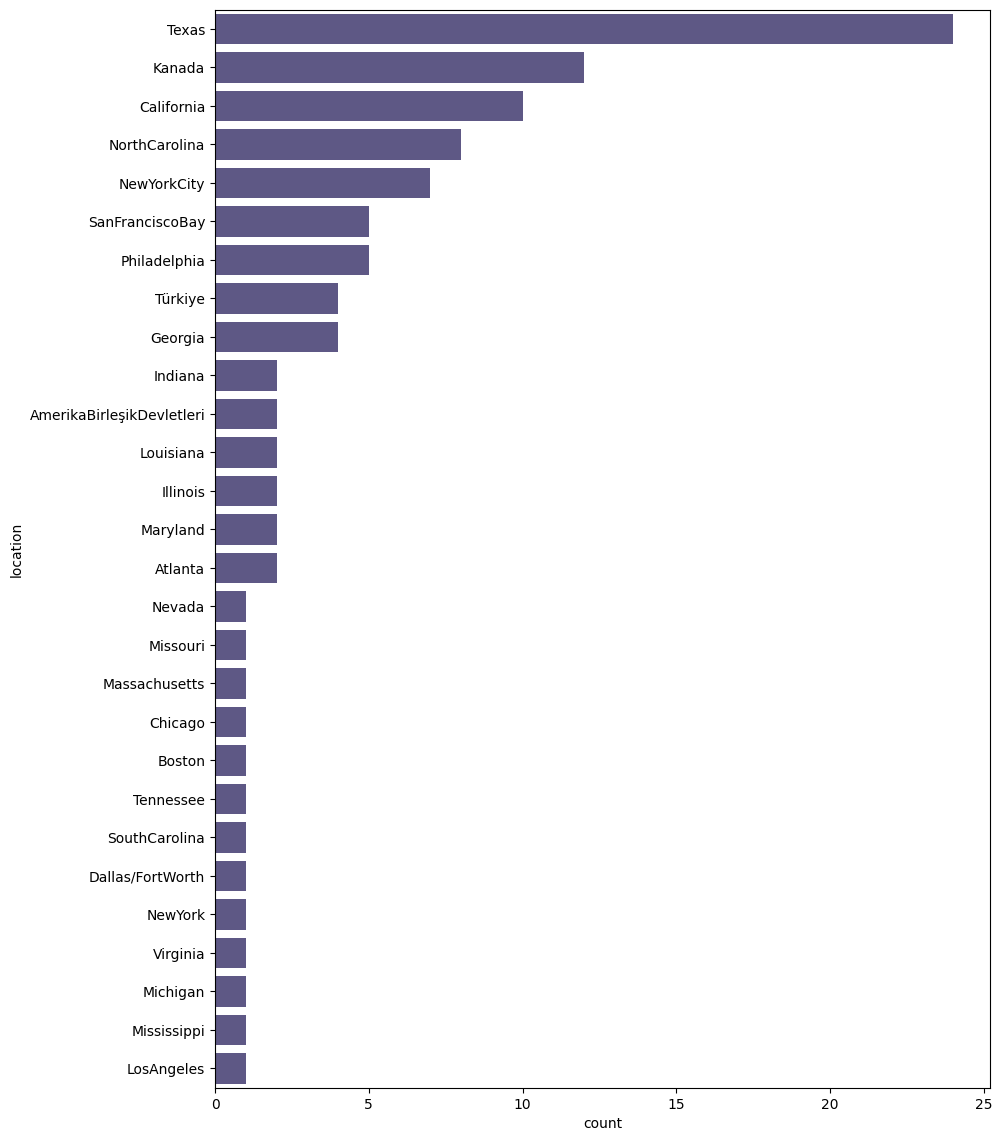

In [4]:
# We will take the last sector of the location data as the location of the candidate
df['location'] = df['location'].apply(lambda x: x.split(',')[-1])

# As there are different naming to the same location, i.e Greater Texas Area vs Texas, 
# we need to strip the location to the same representation
remove_texts = ['Greater', 'Area', ' ']
for text in remove_texts:
    df['location'] = df['location'].apply(lambda x: x.replace(text, ''))

# plot the distribution of the candidates
plt.figure(figsize=(10, 0.5*len(df['location'].value_counts())))
sns.countplot(y='location', data=df, order = df['location'].value_counts().index, color="#58508d")
plt.show()

The locations with the most candidates are Texas, California, North Carolina and NYC. There are also 12 Canadian candidates. Now that we have processed the location data and get the distribution of the candidates, we can see if there is evidence supporting our hypothesis by verifying if candidates from the top locations have more connections than candidates from the other locations.

In [5]:
# First we need to convert connections to numerical
df['connection'] = df['connection'].apply(lambda x: int(x.replace('+', '')))

In [6]:
location_connection_df = df.groupby('location')['connection']\
        .describe()[['count', 'mean']]\
        .sort_values(by='count',ascending=False)\
        .reset_index()
location_connection_df

,location,count,mean
0,Texas,24.0,305.708333
1,Kanada,12.0,243.916667
2,California,10.0,91.700000
3,NorthCarolina,8.0,158.000000
4,NewYorkCity,7.0,79.142857
5,SanFranciscoBay,5.0,500.000000
6,Philadelphia,5.0,500.000000
7,Georgia,4.0,500.000000
8,Türkiye,4.0,500.000000
9,Illinois,2.0,390.000000


There is no evidence supporting the assumption that locations with higher amount of candidates would have higher average connections per candidate. Therefore we will skip it for now and focus on `job_title` and `connection` which are probably more reliable as the criterion for the initial ranking.

We will still consider using `location` when re-ranking the candidates when anyone is starred.

### Wrangling `connection`

As we have converted the connection data into numerical values, we can visualize the connection numbers with a histogram.

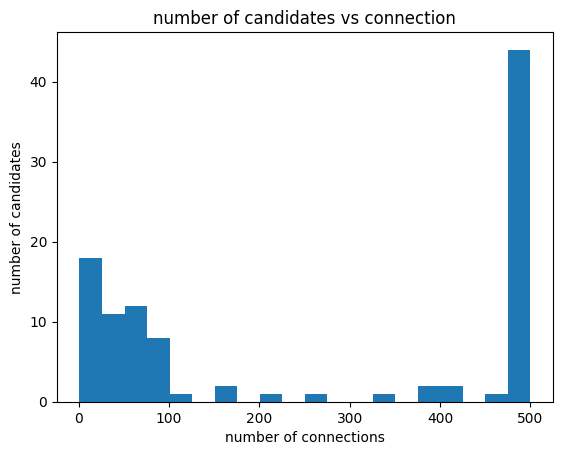

In [7]:
plt.hist(df['connection'], bins=20)
plt.xlabel('number of connections')
plt.ylabel('number of candidates')
plt.title('number of candidates vs connection')
plt.show()

Most of the candidates have either lower than 100 connections or 500+ of connections. Considering the job is regarding human resourcing, it is safe to assume that having more connections should considered an asset.

We can develop a metric called `connection_factor` which is the weight factor of the number of connections with 0 equal to 0 and 500 equal to 1.

In [8]:
df['connection_factor'] = df['connection']/500

We will get the semantics of the `job_title` with embeddings. We will achieve this using BERT Tokenizer.

Leveraging the pretrained AutoTokenizer and AutoModelForSequenceClassification from transformers, we can transform the `job_titles` into a 104*16 numerical matrix which represents the probability of the job title belonging one of the 16 classes determined by AutoModel.

In [9]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 31.7 MB/s eta 0:00:00


In [10]:
KEYWORDS = ['Aspiring human resources', 'seeking human resources']

from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Instantiate the pretrained BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing the words in the job titles into tokens
inputs = tokenizer(list(df['job_title'].values), padding=True, truncation=True, return_tensors="pt")['input_ids']

# Instantiate the pretrained BERT model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=16)

# Transform the data into the 104*16 numerical matrix
outputs = model(inputs)
print(outputs.logits.shape)

# Convert the outputs into probabilities
import torch 
outputs = torch.nn.functional.softmax(outputs.logits, dim = -1)
print(outputs)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

torch.Size([104, 16])
tensor([[0.0630, 0.0602, 0.0401,  ..., 0.0506, 0.0672, 0.0517],
        [0.0602, 0.0568, 0.0482,  ..., 0.0582, 0.0651, 0.0640],
        [0.0661, 0.0569, 0.0535,  ..., 0.0582, 0.0622, 0.0693],
        ...,
        [0.0573, 0.0566, 0.0455,  ..., 0.0543, 0.0662, 0.0624],
        [0.0645, 0.0580, 0.0530,  ..., 0.0573, 0.0618, 0.0660],
        [0.0589, 0.0581, 0.0500,  ..., 0.0563, 0.0691, 0.0651]],
       grad_fn=<SoftmaxBackward0>)


In [11]:
# We will be storing the probabilities into a dataframe
embedding_df = pd.DataFrame(outputs.detach().numpy(), columns=['X'+str(i) for i in range(16)])
embedding_df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
0,0.062964,0.060198,0.040131,0.048076,0.067430,0.045871,0.053043,0.107581,0.044542,0.066008,0.053546,0.077966,0.103101,0.050614,0.067207,0.051723
1,0.060169,0.056768,0.048201,0.053728,0.070254,0.052407,0.060549,0.097555,0.040931,0.063430,0.063406,0.075179,0.070048,0.058200,0.065139,0.064035
2,0.066065,0.056854,0.053549,0.050658,0.069036,0.045996,0.057561,0.098991,0.040322,0.060527,0.064025,0.068054,0.078602,0.058234,0.062223,0.069302
3,0.061584,0.058453,0.052683,0.053860,0.069414,0.049824,0.059158,0.097338,0.040112,0.059751,0.062321,0.074750,0.072178,0.058618,0.063686,0.066271
4,0.064693,0.058623,0.053022,0.050855,0.066398,0.048124,0.058456,0.106661,0.041049,0.060977,0.064133,0.072241,0.070760,0.058572,0.057262,0.068174


Using the same method, we can convert the target keywords into such a matrix and calculate the similarity of each data entry.

In [12]:
# Converting the keywords
keyword_inputs = tokenizer(KEYWORDS, padding=True, truncation=True, return_tensors='pt')['input_ids']
keyword_outputs = model(keyword_inputs)
keyword_outputs = torch.nn.functional.softmax(keyword_outputs.logits, dim = -1)
keyword_outputs = keyword_outputs.detach().numpy()
keyword_outputs

array([[0.07571436, 0.05344454, 0.05869038, 0.04479409, 0.07030213,
        0.04984387, 0.06113625, 0.10442923, 0.0403223 , 0.04434586,
        0.08054728, 0.05667341, 0.08285221, 0.0554332 , 0.05287012,
        0.06860071],
       [0.07208941, 0.05334605, 0.06185922, 0.04804786, 0.07045685,
        0.05209019, 0.05924948, 0.10836069, 0.04172882, 0.04260571,
        0.07747126, 0.05916136, 0.07775283, 0.05704382, 0.05363885,
        0.06509756]], dtype=float32)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculating Cosine Similarities
similarities_df = pd.DataFrame(cosine_similarity(embedding_df.values, keyword_outputs))
similarities_df['similarity'] = similarities_df.max(axis=1)
similarities_df.head()

,0,1,similarity
0,0.975943,0.976202,0.976202
1,0.986136,0.988109,0.988109
2,0.992481,0.992989,0.992989
3,0.988411,0.990291,0.990291
4,0.990892,0.992726,0.992726


In [14]:
# Now we can apply the connection factors that we calculated earlier to complete the initial ranking of the candidates
df['fit_proba'] = similarities_df['similarity'] * df['connection_factor']

# We will also store the similarity score for re-ranking
df['similarity'] = similarities_df['similarity']

df.head()

,id,job_title,location,connection,fit,connection_factor,fit_proba,similarity
0,1,2019 C.T. Bauer College of Business Graduate (...,Texas,85,NaN,0.170,0.165954,0.976202
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500,NaN,1.000,0.988109,0.988109
2,3,Aspiring Human Resources Professional,NorthCarolina,44,NaN,0.088,0.087383,0.992989
3,4,People Development Coordinator at Ryan,Texas,500,NaN,1.000,0.990291,0.990291
4,5,Advisory Board Member at Celal Bayar University,Türkiye,500,NaN,1.000,0.992726,0.992726


In [15]:
# Sort the entries by fit_proba
df.sort_values(by='fit_proba', ascending=False, inplace=True)
df.head()

,id,job_title,location,connection,fit,connection_factor,fit_proba,similarity
25,26,HR Senior Specialist,SanFranciscoBay,500,NaN,1.0,0.993222,0.993222
60,61,HR Senior Specialist,SanFranciscoBay,500,NaN,1.0,0.993222,0.993222
50,51,HR Senior Specialist,SanFranciscoBay,500,NaN,1.0,0.993222,0.993222
37,38,HR Senior Specialist,SanFranciscoBay,500,NaN,1.0,0.993222,0.993222
7,8,HR Senior Specialist,SanFranciscoBay,500,NaN,1.0,0.993222,0.993222


Now that we have generated the initial rankings of the candidates, we can move on to develop the ranking model for re-ranking the candidates in the future. We will be using LGBMRanker as our model and NDCG as the metric. But first, we need to order the data to have a way indicating if a candidate is a good fit for the role. For the purpose of this notebook, we will randomly set the top 40 candidates to be a good fit (1) or not a good fit (0) and set the rest of the candidates to be not a good fit (0).

In [16]:
# Randomly set the top 40 candidats to be a good fit or not
candidates_fit = np.random.randint(2, size=40)

In [17]:
# Concatinate the rest of the candidates
candidates_fit = np.hstack((candidates_fit, np.zeros(df.shape[0]-40)))

In [18]:
# Store the candidates' fitting info
df['fit'] = candidates_fit

Now we split the data into training and testing sets.

In [19]:
from sklearn.model_selection import train_test_split

X = df[['similarity', 'connection']].values
y = df['fit'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=44)

q_train = [X_train.shape[0]]
q_val = [X_val.shape[0]]

print(f'There are {X_train.shape[0]} data points in the training set with {sum(y_train)} positives')
print(f'There are {X_val.shape[0]} data points in the validation set with {sum(y_val)} positives')

There are 83 data points in the training set with 19.0 positives
There are 21 data points in the validation set with 5.0 positives


Now we can move on to developing the ranker model.

In [20]:
import lightgbm

ranker = lightgbm.LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
)

ranker.fit(X_train, y_train, group=q_train,
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_group=[q_train, q_val],
        eval_at=[2, 5, 10, 20], verbose=10, early_stopping_rounds=50)

[10]	training's ndcg@2: 0.613147	training's ndcg@5: 0.786014	training's ndcg@10: 0.791706	training's ndcg@20: 0.676289	valid_1's ndcg@2: 0.386853	valid_1's ndcg@5: 0.514771	valid_1's ndcg@10: 0.742576	valid_1's ndcg@20: 0.742576
[20]	training's ndcg@2: 0.613147	training's ndcg@5: 0.786014	training's ndcg@10: 0.791706	training's ndcg@20: 0.640496	valid_1's ndcg@2: 0.386853	valid_1's ndcg@5: 0.383566	valid_1's ndcg@10: 0.719528	valid_1's ndcg@20: 0.719528
[30]	training's ndcg@2: 0.613147	training's ndcg@5: 0.786014	training's ndcg@10: 0.791706	training's ndcg@20: 0.640496	valid_1's ndcg@2: 0.386853	valid_1's ndcg@5: 0.383566	valid_1's ndcg@10: 0.719528	valid_1's ndcg@20: 0.719528
[40]	training's ndcg@2: 0.613147	training's ndcg@5: 0.786014	training's ndcg@10: 0.791706	training's ndcg@20: 0.640496	valid_1's ndcg@2: 0.386853	valid_1's ndcg@5: 0.383566	valid_1's ndcg@10: 0.719528	valid_1's ndcg@20: 0.719528
[50]	training's ndcg@2: 0.613147	training's ndcg@5: 0.786014	training's ndcg@10: 0.7

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRanker(metric='ndcg', objective='lambdarank')

As the ndcg score for the validation set is significantly lower comparing to the ndcg score for the training set, we could argue that the model is overfitting and we can implement the gridsearch to find the most optimal hyperparameters to mitigate the overfitting issue.

To implement the gridsearch with lightgbm, we would need to customize a prediction and NDCG scoring method.

In [48]:
from scipy.stats import rankdata

# Customized prediction function
def rank(ranker, X):
  output = ranker.predict(X).round(5)
  rankings = rankdata(output, method='min') - 1 # setting minimum relevance to 0
  return (rankings)/max(rankings) # normalize the relevance to be between 0-1

y_pred = rank(ranker, X_val)

In [49]:
y_pred

array([1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 1.])

In [51]:
print(f'There are {int(y_val.sum())} relevant data entries in the validation set')
print(f'But there are {int(y_pred.sum())} entries predicted to be relevant')

There are 5 relevant data entries in the validation set
But there are 11 entries predicted to be relevant


As there are more predicted positives than the true positives, we will only consider the first num_true_pos of the model's prediction when calculating the NDCG score.

In [65]:
import math

# Customized NDCG scoring
def ndcg_at_10(y_pred, y_true, group=None):
    # Reorder the ranks to align with the true ranks
    true_order = np.argsort(y_true)
    y_true = y_true[true_order[::-1]]
    y_pred = y_pred[true_order[::-1]]

    dcg = idcg = 0

    num_true_pos = int(y_true.sum())

    # calculate dcg
    for i in range(10):
      idcg += y_true[i]/math.log2(i+2)

      # only consider the first num_ture_pos predicted relevant items
      if num_true_pos >= 0 and y_pred[i] != 0:
        dcg += y_pred[i]/math.log2(i+2)
        num_true_pos -= 1

    ndcg = dcg/(idcg+1)# idcg+1 to avoid division by zero

    return ndcg

ndcg_at_10(y_pred, y_val)

0.6774844725598165

In [66]:
from sklearn.metrics import make_scorer

ndcg_scorer = make_scorer(ndcg_at_10, greater_is_better=True)

In [ ]:
from sklearn.model_selection import GridSearchCV, GroupKFold

ranking_param_grid = {'n_estimators': [10, 20, 30, 40],
    'num_leaves': [20, 50, 100, 200],
    'max_depth': [5,10,15,20],
    'learning_rate': [0.01, 0.02, 0.03],
}

flatten_group = np.ones(q_train)

gbm = GridSearchCV(ranker, param_grid=ranking_param_grid,
                   scoring=ndcg_scorer, cv=5, verbose=10)

gbm.fit(X_train, y_train, group=flatten_group)

In [76]:
gbm.best_estimator_

LGBMRanker(learning_rate=0.01, max_depth=5, metric='ndcg', n_estimators=10,
           num_leaves=20, objective='lambdarank')

Now that we have found the best configuration for the model, we can simply retrain the model on the new candidates and generate rankings.

In [91]:
# Retrain the model after new candidates are starred
def retraining(X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=44)

  q_train = [X_train.shape[0]]
  q_val = [X_val.shape[0]]

  print(f'There are {X_train.shape[0]} data points in the training set with {sum(y_train)} positives')
  print(f'There are {X_val.shape[0]} data points in the validation set with {sum(y_val)} positives')

  model = lightgbm.LGBMRanker(learning_rate=0.01, max_depth=5, metric='ndcg', n_estimators=10,
           num_leaves=20, objective='lambdarank')
  
  model.fit(X_train, y_train, group=q_train,
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_group=[q_train, q_val],
        eval_at=[2, 5, 10, 20], verbose=10, early_stopping_rounds=50)
  
  return model

In [83]:
# Randomly starring new candidates till we have 30
CANDIDATES = 30

cur = int(y.sum())
print(f'Current starred candidates {cur}')

while cur < CANDIDATES:
  random_choice = np.random.choice(range(len(y)))
  if y[random_choice] == 0:
    y[random_choice] = 1
    cur += 1

print(f'Final starred candidates: {int(y.sum())}')

Current starred candidates 30
Final starred candidates: 30


In [92]:
# Retrain the model
model = retraining(X, y)

There are 83 data points in the training set with 24.0 positives
There are 21 data points in the validation set with 6.0 positives
[10]	training's ndcg@2: 1	training's ndcg@5: 0.83042	training's ndcg@10: 0.681681	training's ndcg@20: 0.688644	valid_1's ndcg@2: 1	valid_1's ndcg@5: 0.699215	valid_1's ndcg@10: 0.832504	valid_1's ndcg@20: 0.832504


/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [96]:
# Rerank the candidates and save the new rankings
df['rankings'] = rank(model, X)

In [98]:
# Reorder the candidates in the dataframe
df.sort_values('rankings', ascending=False)

,id,job_title,location,connection,fit,connection_factor,fit_proba,similarity,rankings
11,12,"SVP, CHRO, Marketing & Communications, CSR Off...",Texas,500,0.0,1.000,0.986564,0.986564,1.0
28,29,Aspiring Human Resources Management student se...,Texas,500,1.0,1.000,0.989787,0.989787,1.0
33,34,People Development Coordinator at Ryan,Texas,500,1.0,1.000,0.990291,0.990291,1.0
46,47,People Development Coordinator at Ryan,Texas,500,1.0,1.000,0.990291,0.990291,1.0
17,18,People Development Coordinator at Ryan,Texas,500,1.0,1.000,0.990291,0.990291,1.0
...,...,...,...,...,...,...,...,...,...
36,37,Student at Humber College and Aspiring Human R...,Kanada,61,0.0,0.122,0.119866,0.982505,0.0
79,80,Junior MES Engineer| Information Systems,SouthCarolina,52,0.0,0.104,0.102269,0.983360,0.0
65,66,Experienced Retail Manager and aspiring Human ...,Texas,57,0.0,0.114,0.111384,0.977055,0.0
24,25,Student at Humber College and Aspiring Human R...,Kanada,61,0.0,0.122,0.119866,0.982505,0.0
